In [1]:
import os
import json
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

class OCTDataset(Dataset):
    def __init__(self, root_dir, indices=None, train=True, is_gentuity=False, transform=None):
        
        self.root_dir = Path(root_dir)
        self.train = train
        self.is_gentuity = is_gentuity
        self.transform = transform
        
        if self.is_gentuity:
            # Gentuity dataset has separate train and test folders
            split_dir = "train" if self.train else "test"
            self.images_dir = self.root_dir / split_dir / "images"
            self.masks_dir = self.root_dir / split_dir / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        else:
            # Terumo dataset has only train data
            self.images_dir = self.root_dir / "train" / "images"
            self.masks_dir = self.root_dir / "train" / "annotations"
            self.samples = sorted(self.images_dir.glob("*.tiff"))
        
        # Filter image paths using indices if provided
        if indices is not None:
            self.samples = [self.samples[i] for i in indices]
        
        else:
            self.samples = sorted(self.images_dir.glob("*.tiff"))
            
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.samples[idx]
        image = Image.open(image_path).convert("RGB")  # Keep it as a PIL Image
        
        # Load the corresponding mask
        mask_path = self.masks_dir / f"{image_path.stem}.json"
        with open(mask_path, "r") as f:
            mask_data = json.load(f)
        
        # Create a binary mask (0 and 1 values)
        mask = np.zeros(image.size[::-1], dtype=np.uint8)  # image.size gives (width, height)
        for coord in mask_data["mask"]:
            x, y = coord
            if 0 <= x < mask.shape[0] and 0 <= y < mask.shape[1]:
                mask[x, y] = 1
        
        mask = Image.fromarray(mask)
        
        # Apply the transformation if available
        if self.transform:
            # Convert image and mask to Tensor
            image = self.transform(image)
            mask = self.transform(mask)
        
        # Add channel dimension for mask
        mask = mask.unsqueeze(0) if len(mask.shape) == 2 else mask  # Add channel if needed

        unique_id = mask_data["unique_id"]
        
        return image, mask, image_path.stem, unique_id  # Returning image filename too

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels // 8, in_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Compute the attention weights
        attention = self.sigmoid(self.conv2(self.sigmoid(self.conv1(x))))
        return x * attention  # Element-wise multiplication

# Define a large U-Net model with Attn
class Net(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, initial_filters=64):
        super(Net, self).__init__()

        self.encoder1 = self.conv_block(input_channels, initial_filters)
        self.encoder2 = self.conv_block(initial_filters, initial_filters * 2)
        self.encoder3 = self.conv_block(initial_filters * 2, initial_filters * 4)
        self.encoder4 = self.conv_block(initial_filters * 4, initial_filters * 8)
        self.encoder5 = self.conv_block(initial_filters * 8, initial_filters * 16)

        self.pool = nn.MaxPool2d(2)

        # Adjusting channels to match attention input
        self.upconv5 = nn.ConvTranspose2d(initial_filters * 16, initial_filters * 8, kernel_size=2, stride=2)
        self.attn5 = AttentionBlock(initial_filters * 16)  # Updated input channels
        self.decoder5 = self.conv_block(initial_filters * 16, initial_filters * 8)

        self.upconv4 = nn.ConvTranspose2d(initial_filters * 8, initial_filters * 4, kernel_size=2, stride=2)
        self.attn4 = AttentionBlock(initial_filters * 8)  # Updated input channels
        self.decoder4 = self.conv_block(initial_filters * 8, initial_filters * 4)

        self.upconv3 = nn.ConvTranspose2d(initial_filters * 4, initial_filters * 2, kernel_size=2, stride=2)
        self.attn3 = AttentionBlock(initial_filters * 4)  # Updated input channels
        self.decoder3 = self.conv_block(initial_filters * 4, initial_filters * 2)

        self.upconv2 = nn.ConvTranspose2d(initial_filters * 2, initial_filters, kernel_size=2, stride=2)
        self.attn2 = AttentionBlock(initial_filters * 2)  # Updated input channels
        self.decoder2 = self.conv_block(initial_filters * 2, initial_filters)

        self.final_conv = nn.Conv2d(initial_filters, output_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))
        e5 = self.encoder5(self.pool(e4))

        # Decoding path with skip connections and attention
        d5 = torch.cat((self.upconv5(e5), e4), dim=1)
        d5 = self.attn5(d5)  # Apply attention
        d5 = self.decoder5(d5)

        d4 = torch.cat((self.upconv4(d5), e3), dim=1)
        d4 = self.attn4(d4)  # Apply attention
        d4 = self.decoder4(d4)

        d3 = torch.cat((self.upconv3(d4), e2), dim=1)
        d3 = self.attn3(d3)  # Apply attention
        d3 = self.decoder3(d3)

        d2 = torch.cat((self.upconv2(d3), e1), dim=1)
        d2 = self.attn2(d2)  # Apply attention
        d2 = self.decoder2(d2)

        # Final output layer
        out = self.final_conv(d2)

        return torch.sigmoid(out)  # Assuming binary segmentation

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):   
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets)

        # Compute Dice Loss
        dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)  
        
        return dice_loss

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1): 
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets)

        # Compute Dice Loss
        dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)  
        bce = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = bce + dice_loss
        
        return Dice_BCE

In [24]:
from tqdm import tqdm
import torch.optim as optim

root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare datasets for the fold
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])

# Initialize model with the hyperparameters from the config
net = Net().to(device)

# Define loss and optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-4)

# Define the loss function
criterion = DiceLoss()

# Split the dataset into training and validation sets
dataset = OCTDataset(root_dir, transform=transform)
val_size = int(0.1 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

epochs = 10

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_pixels = 0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for images, masks, _, _ in progress_bar:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        progress_bar.set_postfix(loss=loss.item())

        # Calculate training accuracy (pixel-wise accuracy)
        pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
        correct_train_predictions += torch.sum(pred == masks).item()
        total_train_pixels += masks.numel()

        progress_bar.set_postfix(loss=loss.item())

    # Calculate training loss and accuracy for the epoch
    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = correct_train_predictions / total_train_pixels
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    net.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_pixels = 0
    with torch.no_grad():  # No need to calculate gradients during validation
        for images, masks, _, _ in tqdm(valloader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            outputs = net(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

            # Calculate validation accuracy (pixel-wise accuracy)
            pred = (outputs > 0.5).float()  # Assuming binary classification (adjust for multi-class)
            correct_val_predictions += torch.sum(pred == masks).item()
            total_val_pixels += masks.numel()

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(valloader.dataset)
    val_accuracy = correct_val_predictions / total_val_pixels
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/10], Training Loss: 0.9986, Training Accuracy: 0.7782


Epoch [1/10], Validation Loss: 0.9991, Validation Accuracy: 0.8837


Epoch [2/10], Training Loss: 0.9983, Training Accuracy: 0.8624


Epoch [2/10], Validation Loss: 0.9978, Validation Accuracy: 0.8760


Epoch [3/10], Training Loss: 0.9981, Training Accuracy: 0.8916


Epoch [3/10], Validation Loss: 0.9976, Validation Accuracy: 0.8778


Epoch [4/10], Training Loss: 0.9980, Training Accuracy: 0.8948


Epoch [4/10], Validation Loss: 0.9980, Validation Accuracy: 0.7579


Epoch [5/10], Training Loss: 0.9979, Training Accuracy: 0.8949


Epoch [5/10], Validation Loss: 0.9974, Validation Accuracy: 0.8825


Epoch [6/10], Training Loss: 0.9978, Training Accuracy: 0.9003


Epoch [6/10], Validation Loss: 0.9973, Validation Accuracy: 0.8852


Epoch [7/10], Training Loss: 0.9976, Training Accuracy: 0.9038


Epoch [7/10], Validation Loss: 0.9974, Validation Accuracy: 0.8373


Epoch [8/10], Training Loss: 0.9975, Training Accuracy: 0.9018


Epoch [8/10], Validation Loss: 0.9971, Validation Accuracy: 0.8823


Epoch [9/10], Training Loss: 0.9973, Training Accuracy: 0.9023


Epoch [9/10], Validation Loss: 0.9969, Validation Accuracy: 0.8805


Epoch [10/10], Training Loss: 0.9972, Training Accuracy: 0.9061


Epoch [10/10], Validation Loss: 0.9967, Validation Accuracy: 0.8874


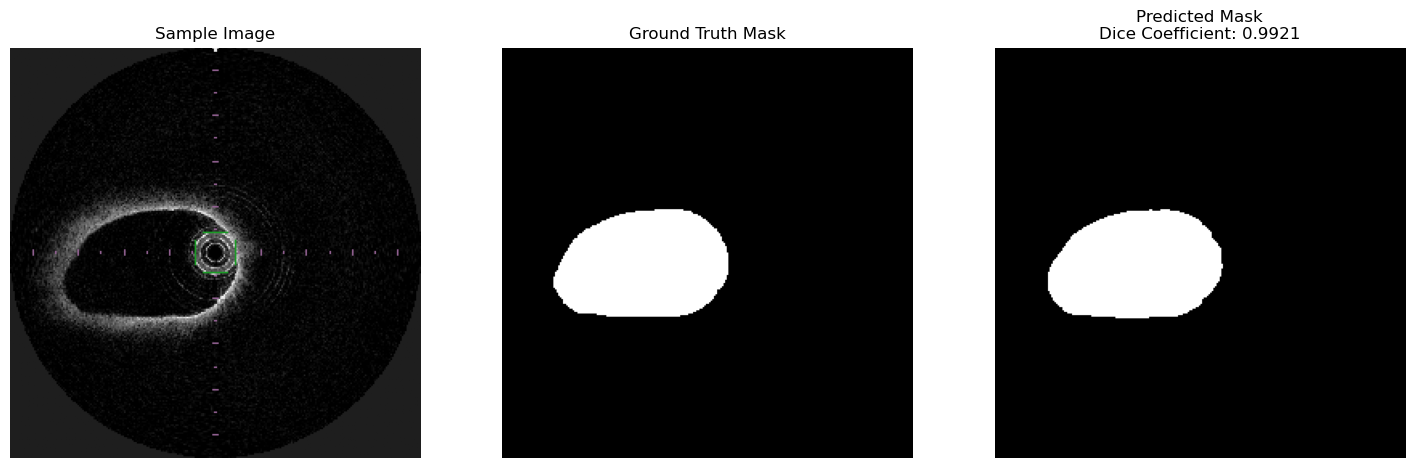

In [76]:
# Set the model to evaluation mode
net.eval()

# Load a sample image from the dataset
sample_image, sample_mask, _, _ = dataset[50]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = net(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Calculate Dice coefficient
dice_coefficient = criterion(predicted_mask, sample_mask.to(device))

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title(f"Predicted Mask\nDice Coefficient: {dice_coefficient:.4f}")
ax[2].axis('off')

plt.show()

In [ ]:
import numpy as np
import os
import tempfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from filelock import FileLock
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from typing import Dict
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from ray import tune, air
from ray.air import session
from ray.tune.search.optuna import OptunaSearch
from tqdm import tqdm

def train_model(config):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    net = Net().to(device)

    # Select optimizer based on the configuration
    if config["optimizer"] == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    elif config["optimizer"] == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    elif config["optimizer"] == "RMSprop":
        optimizer = optim.RMSprop(net.parameters(), lr=config["lr"])

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    if config["smoke_test"]:
        # Split the dataset into training and validation sets
        root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo_smoke_test"
        dataset = OCTDataset(root_dir, transform=transform)
        val_size = int(0.1 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

        trainloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
        valloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    else:
        print("Training on full dataset")

    best_val_loss = float("inf")
    epochs = config["epochs"]
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        epoch_steps= 0

        for i, data in enumerate(trainloader):
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = net(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

            epoch_steps += 1
            if i % 10 == 9:  # print every 10 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                loss.item()))


        # Calculate training loss and accuracy for the epoch
        train_loss = running_loss / len(trainloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss:.4f}")

        # Validation phase
        net.eval()
        val_loss = 0.0

        with torch.no_grad():  # No need to calculate gradients during validation
            for data in valloader:
                images, masks, _, _ = data
                images, masks = images.to(device), masks.to(device)

                outputs = net(images)
                prediction = (outputs > 0.5).float()
                loss = dice_loss(prediction, masks)
                val_loss += loss.item() * images.size(0)
        
        # Calculate validation loss and accuracy
        val_loss = val_loss / len(valloader.dataset)
        
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {val_loss:.4f}")

        # Save checkpoint if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print(f"Validation loss improved to {val_loss:.4f}. Saving checkpoint.")
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save(
                    (net.state_dict(), optimizer.state_dict()), path
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                train.report(
                    {"loss": val_loss, "accuracy": 1 - val_loss},
                    checkpoint=checkpoint,
                )
        else:
            print(f"Validation loss did not improve. Best so far: {best_val_loss:.4f}")
        
    print("Finished Training")

def test_best_model(best_result):
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")
    best_trained_model = Net().to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
    best_trained_model.load_state_dict(model_state)

    transform = transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"

    test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
    testloader = DataLoader(test_dataset, batch_size=best_result.config["batch_size"], shuffle=False)

    total_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for data in testloader:
            images, masks, _, _ = data
            images, masks = images.to(device), masks.to(device)

            outputs = best_trained_model(images)
            predicted = (outputs > 0.5).float()
            loss = dice_loss(predicted, masks)
            total_loss += loss.item() * images.size(0)

    # Calculate average loss and accuracy
    total_loss /= len(testloader.dataset)
    accuracy = 1 - loss
    
    print(f"Test Loss: {total_loss:.4f}, Test Accuracy: {accuracy:.4f}")

c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-23 16:52:48,897	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-23 16:52:49,851	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
from ray.tune.search.optuna import OptunaSearch

# Custom function to shorten trial directory names
def trial_dirname_creator(trial):
    # Shorten the trial name to only include key parameters
    return f"trial_{trial.trial_id}_lr={trial.config['lr']:.1e}_opt={trial.config['optimizer']}_bs={trial.config['batch_size']}"

def main(num_samples, gpus_per_trial, epochs, smoke_test):
    config = {
        "lr": 1e-4,
        "epochs": epochs,
        "smoke_test": smoke_test,
        "batch_size": tune.choice([2]),
        "optimizer": tune.choice(["Adam", "SGD", "RMSprop"]),
    }

    scheduler = ASHAScheduler(
        max_t=config["epochs"],
        grace_period=1,
        reduction_factor=2
    )

    algo = OptunaSearch()

    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_model),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            search_alg=algo,
            scheduler=scheduler,
            num_samples=num_samples,
            trial_dirname_creator=trial_dirname_creator,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=4, gpus_per_trial=1, epochs=1, smoke_test=True)

(train_model pid=2084) [1,    10] loss: 0.999
(train_model pid=2084) [1,    20] loss: 1.000
(train_model pid=2084) [1,    30] loss: 1.000
(train_model pid=2084) [1,    40] loss: 1.000
(train_model pid=2084) [1,    50] loss: 0.998
(train_model pid=2084) [1,    60] loss: 1.000
(train_model pid=2084) [1,    70] loss: 1.000
(train_model pid=2084) [1,    80] loss: 1.000
(train_model pid=2084) Epoch [1/1], Training Loss: 0.9992
(train_model pid=2084) Epoch [1/1], Validation Loss: 0.9993
(train_model pid=2084) Validation loss improved to 0.9993. Saving checkpoint.


(train_model pid=2084) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_2024-11-23_16-52-57/trial_8803a765_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


(train_model pid=25996) [1,    10] loss: 0.999
(train_model pid=25996) [1,    20] loss: 0.999
(train_model pid=25996) [1,    30] loss: 0.999
(train_model pid=25996) [1,    40] loss: 0.999
(train_model pid=25996) [1,    50] loss: 0.999
(train_model pid=25996) [1,    60] loss: 0.998
(train_model pid=25996) [1,    70] loss: 0.999
(train_model pid=25996) [1,    80] loss: 0.999
(train_model pid=25996) Epoch [1/1], Training Loss: 0.9984
(train_model pid=25996) Epoch [1/1], Validation Loss: 0.9971
(train_model pid=25996) Validation loss improved to 0.9971. Saving checkpoint.


(train_model pid=25996) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_2024-11-23_16-52-57/trial_ffbad4eb_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model pid=26960) [1,    10] loss: 0.998
(train_model pid=26960) [1,    20] loss: 0.999
(train_model pid=26960) [1,    30] loss: 0.999
(train_model pid=26960) [1,    40] loss: 0.999
(train_model pid=26960) [1,    50] loss: 0.999
(train_model pid=26960) [1,    60] loss: 0.999
(train_model pid=26960) [1,    70] loss: 0.999
(train_model pid=26960) [1,    80] loss: 0.995
(train_model pid=26960) Epoch [1/1], Training Loss: 0.9983
(train_model pid=26960) Epoch [1/1], Validation Loss: 0.9932
(train_model pid=26960) Validation loss improved to 0.9932. Saving checkpoint.


(train_model pid=26960) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_2024-11-23_16-52-57/trial_2a21f266_lr=1.0e-04_opt=RMSprop_bs=2/checkpoint_000000)


(train_model pid=26428) [1,    10] loss: 0.999
(train_model pid=26428) [1,    20] loss: 0.999
(train_model pid=26428) [1,    30] loss: 1.000
(train_model pid=26428) [1,    40] loss: 0.999
(train_model pid=26428) [1,    50] loss: 0.998
(train_model pid=26428) [1,    60] loss: 1.000
(train_model pid=26428) [1,    70] loss: 1.000
(train_model pid=26428) [1,    80] loss: 1.000
(train_model pid=26428) Epoch [1/1], Training Loss: 0.9992
(train_model pid=26428) Epoch [1/1], Validation Loss: 0.9991
(train_model pid=26428) Validation loss improved to 0.9991. Saving checkpoint.


2024-11-23 16:55:41,970	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/johan/ray_results/train_model_2024-11-23_16-52-57' in 0.0170s.
2024-11-23 16:55:41,979	INFO tune.py:1041 -- Total run time: 154.62 seconds (154.48 seconds for the tuning loop).
(train_model pid=26428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/johan/ray_results/train_model_2024-11-23_16-52-57/trial_b29ab737_lr=1.0e-04_opt=SGD_bs=2/checkpoint_000000)


Best trial config: {'lr': 0.0001, 'epochs': 1, 'smoke_test': True, 'batch_size': 2, 'optimizer': 'RMSprop'}
Best trial final validation loss: 0.9931530687544081
Best trial final validation accuracy: 0.006846931245591881
Test Loss: 0.9979, Test Accuracy: 0.0007


c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\ray\train\_internal\session.py:651: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Loading results from C:\Users\johan\ray_results\train_model_2024-11-23_16-28-15...
No errors!
Number of results: 4
Trial #0 finished successfully with a loss of: 0.9991224937968783, batch size: 2
Trial #1 finished successfully with a loss of: 0.9923042721218533, batch size: 2
Trial #2 finished successfully with a loss of: 0.9923774202664694, batch size: 2
Trial #3 finished successfully with a loss of: 0.9985821975602044, batch size: 2
Shortest training time: 28.538614988327026
Longest training time: 148.681245803833
Best trial config: {'lr': 0.0001, 'epochs': 5, 'smoke_test': True, 'batch_size': 2, 'optimizer': 'Adam'}
Best trial final test set loss: 0.9923042721218533
Best trial final test set accuracy: 0.007695727878146652


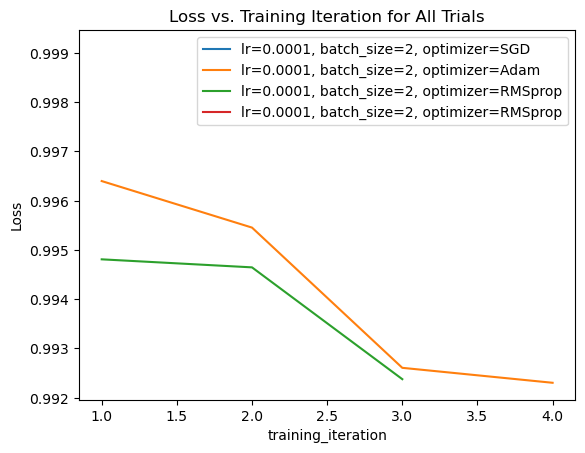

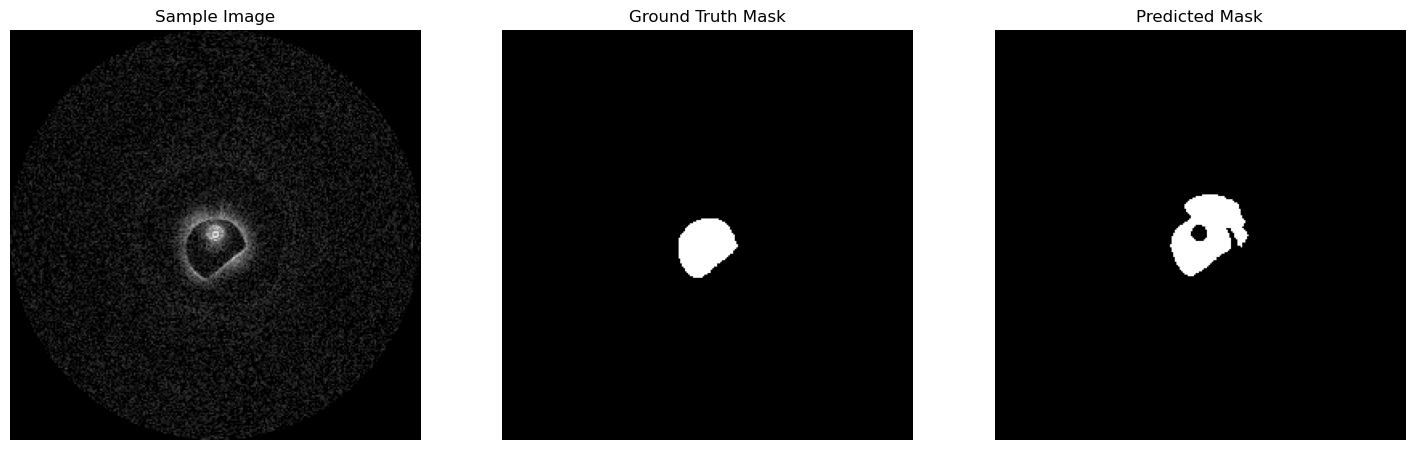

In [20]:
storage_path = r"C:\Users\johan\ray_results"
exp_name = "train_model_2024-11-23_16-28-15"
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")

restored_tuner = tune.Tuner.restore(experiment_path, trainable=train_model)
result_grid = restored_tuner.get_results()

# Check if there have been errors
if result_grid.errors:
    print("One of the trials failed!")
else:
    print("No errors!")

num_results = len(result_grid)
print("Number of results:", num_results)

# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a loss of: {result.metrics['loss']}, "
        f"batch size: {result.config['batch_size']}"
    )

results_df = result_grid.get_dataframe()
results_df[["training_iteration", "loss"]]

print("Shortest training time:", results_df["time_total_s"].min())
print("Longest training time:", results_df["time_total_s"].max())

ax = None
for result in result_grid:
    label = f"lr={result.config['lr']:.4f}, batch_size={result.config['batch_size']}, optimizer={result.config['optimizer']}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "loss", ax=ax, label=label)
ax.set_title("Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Loss")

from ray.train import Result

# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

print("Best trial config: {}".format(best_result.config))

# Get the best trial's final loss and accuracy
best_loss = best_result.metrics["loss"]
print("Best trial final test set loss: {}".format(best_loss))
best_accuracy = best_result.metrics["accuracy"]
print("Best trial final test set accuracy: {}".format(best_accuracy))

# Load the best model
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

best_trained_model = Net().to(device)

# Load the best checkpoint
checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True)
best_trained_model.load_state_dict(model_state)

# Set the model to evaluation mode
best_trained_model.eval()

# Load a sample image from the test dataset
root_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.ToTensor(),
])
test_dataset = OCTDataset(root_dir, transform=transform, train=False, is_gentuity=True)
random_indices = np.random.choice(len(test_dataset), 1, replace=False)
sample_image, sample_mask, _, _ = test_dataset[random_indices[0]]  # Change the index to load a different sample

# Move the sample image to the appropriate device
sample_image = sample_image.to(device).unsqueeze(0)  # Add batch dimension

# Make a prediction
with torch.no_grad():
    prediction = best_trained_model(sample_image)

# Convert the prediction to a binary mask
predicted_mask = (prediction > 0.5).float()

# Plot the sample image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(sample_image.squeeze().permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Sample Image")
ax[0].axis('off')

ax[1].imshow(sample_mask.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')

ax[2].imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()
